In [1]:
import re
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences

import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from gensim.models import Word2Vec
from textblob import TextBlob
import emoji


2023-04-25 23:01:44.324410: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
[nltk_data] Downloading package stopwords to /Users/owen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
df = pd.read_csv('/Users/owen/Desktop/FYP/tweet_data.csv', encoding = 'latin',header = None)

In [4]:
df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
df.shape

(1600000, 6)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   0       1600000 non-null  int64 
 1   1       1600000 non-null  int64 
 2   2       1600000 non-null  object
 3   3       1600000 non-null  object
 4   4       1600000 non-null  object
 5   5       1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


## Data Preprocessing

In [7]:
df.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text']
df = df.sample(frac = 1)

In [8]:
df = df.drop(['id', 'date', 'query', 'user_id'], axis=1)
df['sentiment'] = df['sentiment'].replace([0], 'Negative')
df['sentiment'] = df['sentiment'].replace([4], 'Positive')
df = df.dropna(axis='columns')

In [9]:
df.head()

,sentiment,text
1097554,Positive,@ricklondon ... but i cannot get a reply. Mayb...
1592667,Positive,@hethur240 so you have to run around in the s...
1595177,Positive,only one day of school this week and going to...
454920,Negative,Texting friends that don't text back. You know...
986941,Positive,@rc55 how long has that account been lying dor...


[Text(0.5, 1.0, 'Figure 1: Sentiment in Tweet')]

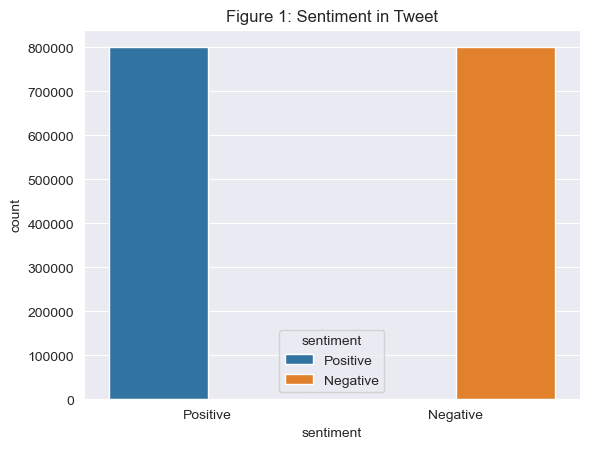

In [10]:
sns.set_style('darkgrid')

sns.countplot(data=df, x="sentiment", hue="sentiment").set(title='Figure 1: Sentiment in Tweet')


#### Data Cleaning

In [11]:
df['clean_text'] = df['text'].str.replace("@", "")
df['clean_text'] = df['clean_text'].str.replace(r"http\S+", "")
df['clean_text'] = df['clean_text'].str.replace("[^a-zA-Z]", " ")
df.head()

,sentiment,text,clean_text
1097554,Positive,@ricklondon ... but i cannot get a reply. Mayb...,ricklondon ... but i cannot get a reply. Maybe...
1592667,Positive,@hethur240 so you have to run around in the s...,hethur240 so you have to run around in the st...
1595177,Positive,only one day of school this week and going to...,only one day of school this week and going to...
454920,Negative,Texting friends that don't text back. You know...,Texting friends that don't text back. You know...
986941,Positive,@rc55 how long has that account been lying dor...,rc55 how long has that account been lying dorm...


#### Stopwords

In [12]:
stopwords = nltk.corpus.stopwords.words('english')

In [13]:
def remove_stopwords(text):
    clean_text=' '.join([word for word in text.split() if word not in stopwords])
    return clean_text

df['clean_text'] = df['clean_text'].apply(lambda text : remove_stopwords(text.lower()))
df['clean_text'] = df['clean_text'].apply(lambda x: x.split())

#### Stemming

In [14]:
from nltk.stem.porter import *
stemmer = PorterStemmer() 
df['clean_text'] = df['clean_text'].apply(lambda x: [stemmer.stem(i) for i in x])
df['clean_text'] = df['clean_text'].apply(lambda x: ' '.join([w for w in x]))
df['clean_text'] = df['clean_text'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 3]))
df.head()

,sentiment,text,clean_text
1097554,Positive,@ricklondon ... but i cannot get a reply. Mayb...,ricklondon cannot reply. mayb someth chariti
1592667,Positive,@hethur240 so you have to run around in the s...,hethur240 around storm pee?
1595177,Positive,only one day of school this week and going to...,"school week look hous tomorrow, move away kaufman"
454920,Negative,Texting friends that don't text back. You know...,text friend text back. know happi right now? o...
986941,Positive,@rc55 how long has that account been lying dor...,"rc55 long account dormant? week? 90000 emails,..."


## Data Visualization

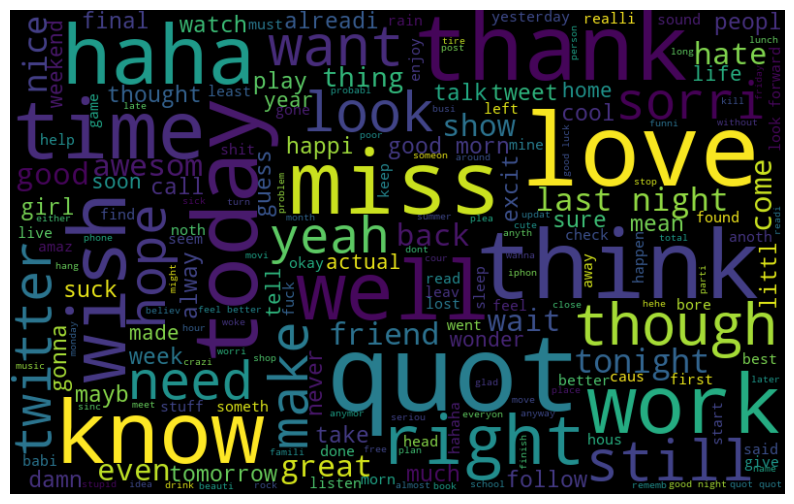

In [37]:
from wordcloud import WordCloud 
import itertools
import collections

all_words = ' '.join([text for text in df['clean_text']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words) 
all_words_list = all_words.split()

plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off') 
plt.show()

In [41]:
all_words_count = collections.Counter(all_words_list)
all_words_count.most_common(15)

[('good', 92591),
 ('work', 87874),
 ('like', 83846),
 ('love', 83065),
 ('quot', 73384),
 ('today', 68712),
 ('time', 66416),
 ('thank', 59438),
 ('miss', 57671),
 ('back', 57417),
 ('want', 57350),
 ('know', 54969),
 ('feel', 51267),
 ('think', 51207),
 ('realli', 50084)]

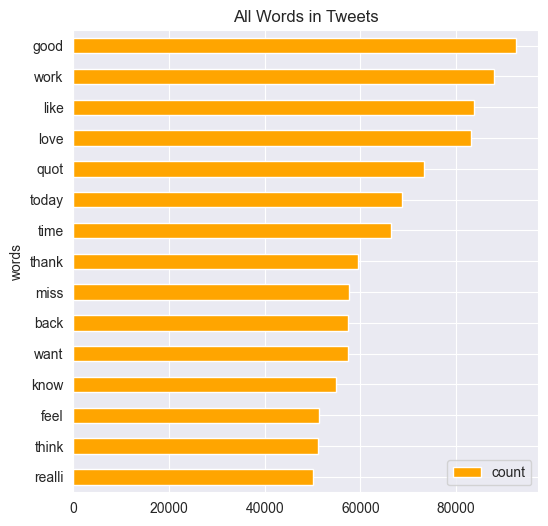

In [42]:
df_all_words_count = pd.DataFrame(all_words_count.most_common(15),
                             columns=['words', 'count'])

fig, ax = plt.subplots(figsize=(6, 6))

df_all_words_count.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="orange")

ax.set_title("All Words in Tweets")

plt.show()

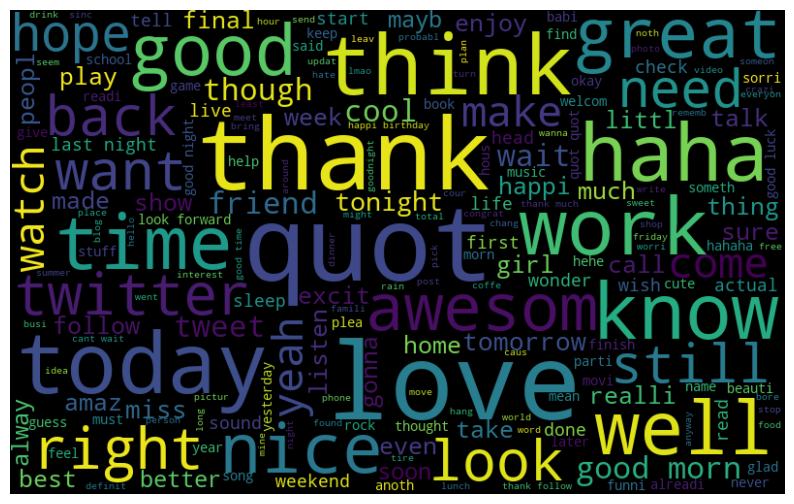

In [38]:
positive_words =' '.join([text for text in df['clean_text'][df['sentiment'] == 'Positive']]) 
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(positive_words)
pos_words_list = positive_words.split()

plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off') 
plt.show()

In [43]:
pos_words_count = collections.Counter(pos_words_list)
pos_words_count.most_common(15)

[('good', 62887),
 ('love', 61123),
 ('thank', 51087),
 ('quot', 46983),
 ('like', 40575),
 ('time', 34623),
 ('today', 30341),
 ('work', 28822),
 ('know', 27270),
 ('watch', 25477),
 ('great', 25434),
 ('hope', 24571),
 ('night', 24544),
 ('think', 24335),
 ('back', 24041)]

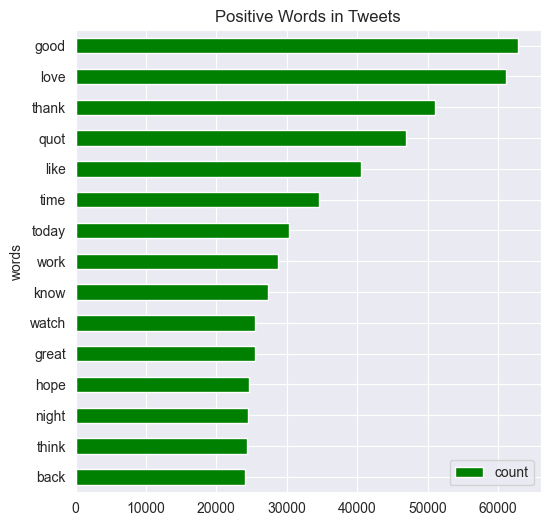

In [44]:
df_pos_words_count = pd.DataFrame(pos_words_count.most_common(15),
                             columns=['words', 'count'])

fig, ax = plt.subplots(figsize=(6, 6))

df_pos_words_count.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="green")

ax.set_title("Positive Words in Tweets")

plt.show()

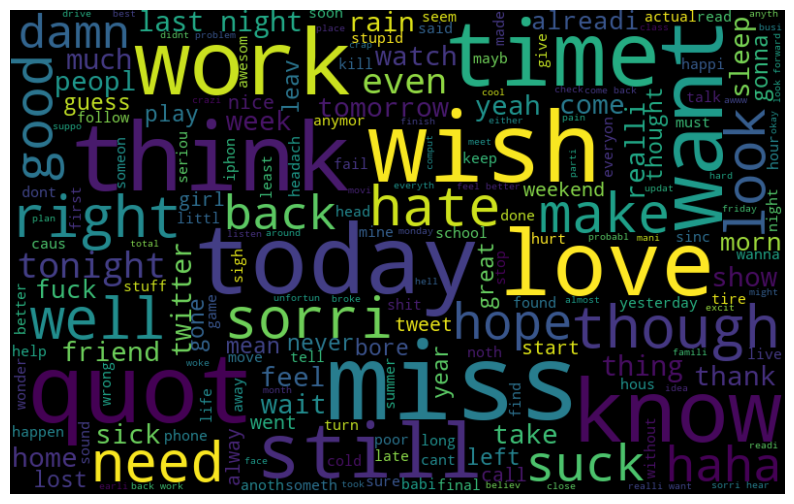

In [39]:
negative_words =' '.join([text for text in df['clean_text'][df['sentiment'] == 'Negative']]) 
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(negative_words)
neg_words_list = negative_words.split()

plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off') 
plt.show()

In [45]:
neg_words_count = collections.Counter(neg_words_list)
neg_words_count.most_common(15)

[('work', 59052),
 ('miss', 47940),
 ('like', 43271),
 ('want', 40287),
 ('today', 38371),
 ('feel', 36918),
 ('back', 33376),
 ('time', 31793),
 ('realli', 31533),
 ('good', 29704),
 ('still', 29291),
 ('know', 27699),
 ('think', 26872),
 ('wish', 26594),
 ('need', 26529)]

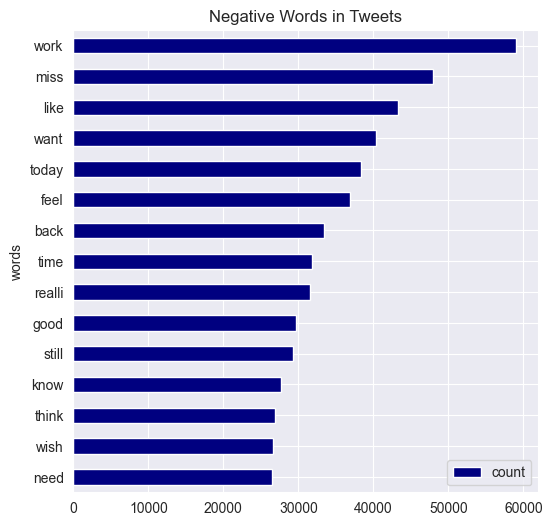

In [46]:
df_neg_words_count = pd.DataFrame(neg_words_count.most_common(15),
                             columns=['words', 'count'])

fig, ax = plt.subplots(figsize=(6, 6))

df_neg_words_count.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="navy")

ax.set_title("Negative Words in Tweets")

plt.show()

## Word Embedding

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    df['clean_text'], df['sentiment'], test_size = 0.2, random_state = 0)

#### TF-IDF

In [16]:
vectorizer = TfidfVectorizer(max_df=0.90, min_df=0.02, max_features=1000)
vectorizer.fit(X_train)
vectorizer.fit(X_test)

TfidfVectorizer(max_df=0.9, max_features=1000, min_df=0.02)

In [17]:
vector_X_train = vectorizer.transform(X_train)
vector_X_test  = vectorizer.transform(X_test)

#### Bag of Words

In [50]:
train, test = train_test_split(df, test_size=0.2, random_state=15)

In [51]:
a = Tokenizer()
a.fit_on_texts(train.clean_text)

In [52]:
maxcount = df['clean_text'].apply(lambda x: len(x.split())).max()

In [53]:
maxcount

30

In [54]:
train1 = a.texts_to_sequences(train.clean_text)
test1 = a.texts_to_sequences(test.clean_text)

In [55]:
bag_X_train = pad_sequences(train1, maxlen=maxcount, padding="post")
bag_X_test = pad_sequences(test1, maxlen=maxcount, padding="post")

bag_y_train = train.sentiment.values
bag_y_test = test.sentiment.values

In [56]:
bag_X_train.shape

(1280000, 30)

## Modeling (using TF-IDF)

#### Logistic Regression

In [39]:
LR = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LR.fit(vector_X_train, y_train)

LogisticRegression(C=2, max_iter=1000, n_jobs=-1)

In [40]:
y_pred_LR = LR.predict(vector_X_test)
print(classification_report(y_test, y_pred_LR))

              precision    recall  f1-score   support

    Negative       0.66      0.41      0.51    159905
    Positive       0.57      0.79      0.67    160095

    accuracy                           0.60    320000
   macro avg       0.62      0.60      0.59    320000
weighted avg       0.62      0.60      0.59    320000



In [91]:
cf_matrix_LR = confusion_matrix(y_test, y_pred_LR)
print(cf_matrix_LR)

[[118646  41813]
 [ 35349 124192]]


<AxesSubplot: >

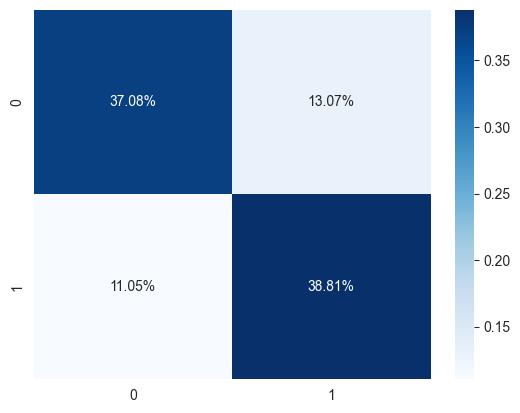

In [92]:
sns.heatmap(cf_matrix_LR/np.sum(cf_matrix_LR), annot=True, 
            fmt='.2%', cmap='Blues')

#### Naive Bayes

In [60]:
NB = BernoulliNB(alpha = 2)
NB.fit(vector_X_train, y_train)

BernoulliNB(alpha=2)

In [39]:
y_pred_NB = NB.predict(vector_X_test)v
print(classification_report(y_test, y_pred_NB))

              precision    recall  f1-score   support

    Negative       0.77      0.74      0.75    160459
    Positive       0.75      0.78      0.76    159541

    accuracy                           0.76    320000
   macro avg       0.76      0.76      0.76    320000
weighted avg       0.76      0.76      0.76    320000



In [40]:
cf_matrix_NB = confusion_matrix(y_test, y_pred_NB)
print(cf_matrix_NB)

[[118487  41972]
 [ 35043 124498]]


<AxesSubplot: >

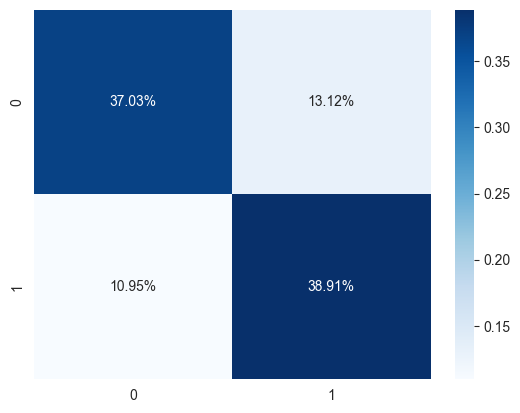

In [41]:
sns.heatmap(cf_matrix_NB/np.sum(cf_matrix_NB), annot=True, 
            fmt='.2%', cmap='Blues')

#### Random Forest

In [32]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(vector_X_train,y_train)

RandomForestClassifier()

In [33]:
y_pred_rf = rf.predict(vector_X_test)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

    Negative       0.66      0.42      0.51    159905
    Positive       0.57      0.79      0.66    160095

    accuracy                           0.60    320000
   macro avg       0.62      0.60      0.59    320000
weighted avg       0.62      0.60      0.59    320000



In [36]:
cf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
print(cf_matrix_rf)

[[ 66363  93542]
 [ 34117 125978]]


<Axes: >

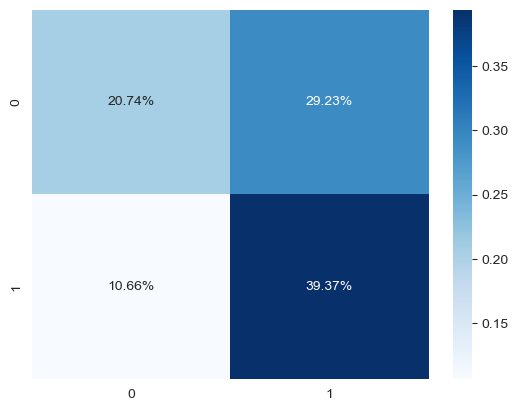

In [37]:
sns.heatmap(cf_matrix_rf/np.sum(cf_matrix_rf), annot=True, 
            fmt='.2%', cmap='Blues')

## Modeling (using Bag of Words)

#### K-Nearest Neighbors

In [59]:
KNN = KNeighborsClassifier(n_neighbors=16)
KNN.fit(bag_X_train, bag_y_train)

KNeighborsClassifier(n_neighbors=16)

In [60]:
y_pred_KNN = KNN.predict(bag_X_test)
print(classification_report(bag_y_test, y_pred_KNN))

              precision    recall  f1-score   support

           0       0.51      0.61      0.56      1492
           4       0.52      0.41      0.46      1508

    accuracy                           0.51      3000
   macro avg       0.51      0.51      0.51      3000
weighted avg       0.51      0.51      0.51      3000



In [61]:
cf_matrix_KNN = confusion_matrix(bag_y_test, y_pred_KNN)
print(cf_matrix_KNN)

[[915 577]
 [890 618]]


<AxesSubplot: >

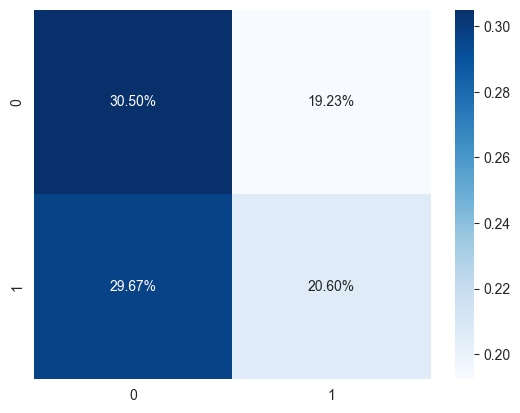

In [62]:
sns.heatmap(cf_matrix_KNN/np.sum(cf_matrix_KNN), annot=True, 
            fmt='.2%', cmap='Blues')

#### Decision Tree

In [63]:
D_Tree = DecisionTreeClassifier(criterion='entropy', max_depth=4)
D_Tree.fit(bag_X_train, bag_y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=4)

In [64]:
y_pred_DTree = D_Tree.predict(bag_X_test)
print(classification_report(bag_y_test, y_pred_DTree))

              precision    recall  f1-score   support

           0       0.52      0.89      0.66      1492
           4       0.64      0.19      0.29      1508

    accuracy                           0.54      3000
   macro avg       0.58      0.54      0.48      3000
weighted avg       0.58      0.54      0.48      3000



In [66]:
cf_matrix_DTree = confusion_matrix(bag_y_test, y_pred_DTree)
print(cf_matrix_DTree)

[[1333  159]
 [1220  288]]


<AxesSubplot: >

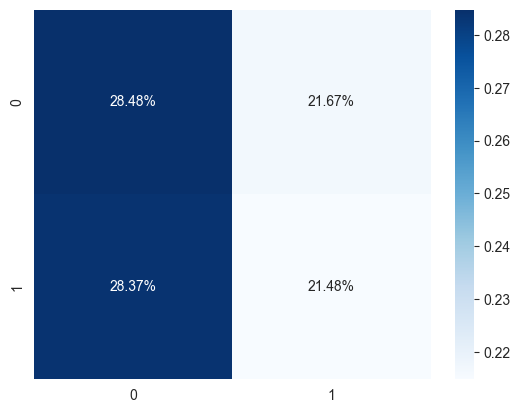

In [46]:
sns.heatmap(cf_matrix_DTree/np.sum(cf_matrix_DTree), annot=True, 
            fmt='.2%', cmap='Blues')

#### Support Vector Machine

In [67]:
SVM = svm.SVC(kernel='rbf')
SVM.fit(bag_X_train, bag_y_train)

SVC()

In [68]:
y_pred_SVM = SVM.predict(bag_X_test)
print(classification_report(bag_y_test, y_pred_SVM))

              precision    recall  f1-score   support

           0       0.50      0.79      0.61      1492
           4       0.52      0.22      0.31      1508

    accuracy                           0.50      3000
   macro avg       0.51      0.51      0.46      3000
weighted avg       0.51      0.50      0.46      3000



In [69]:
cf_matrix_SVM = confusion_matrix(bag_y_test, y_pred_SVM)
print(cf_matrix_SVM)

[[1180  312]
 [1176  332]]


<AxesSubplot: >

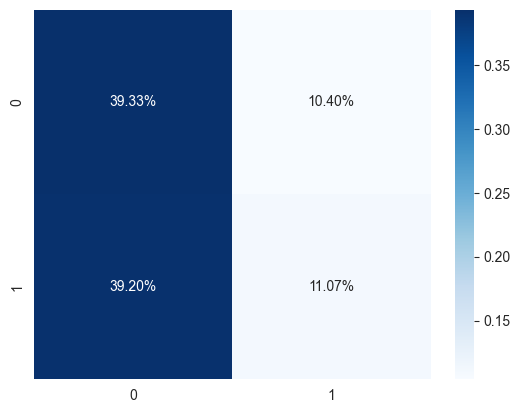

In [70]:
sns.heatmap(cf_matrix_SVM/np.sum(cf_matrix_SVM), annot=True, 
            fmt='.2%', cmap='Blues')

## Application

In [9]:
pos_text = vectorizer.transform(['Today is a good day'])
print(NB.predict(pos_text))

['positive']


In [330]:
pos_text = vectorizer.transform(['Today is a good day'])
print(NB.predict(pos_text))

['positive']


In [332]:
neg_text = vectorizer.transform(['The book is awful'])
print(NB.predict(neg_text))

['negative']


In [14]:
input_text = str(input("Please input the text: "))
result = vectorizer.transform([input_text])
print(NB.predict(result))

Please input the text: The taste of the burger in mcdonald is bad
['negative']


In [304]:
import snscrape.modules.twitter as sntwitter
import pandas as pd

query = "(from:elonmusk) until:2023-03-01 since:2020-01-01"
tweets = []
limit = 50000


for tweet in sntwitter.TwitterSearchScraper(query).get_items():
    
    # print(vars(tweet))
    # break
    if len(tweets) == limit:
        break
    else:
        tweets.append([tweet.date, tweet.username, tweet.content])
        
df1 = pd.DataFrame(tweets, columns=['Date', 'User', 'Tweet'])


/var/folders/y7/w5jvctms1cj6hxymq1tzq5l40000gn/T/ipykernel_83311/1810778559.py:16: DeprecatedFeatureWarning: username is deprecated, use user.username instead
  tweets.append([tweet.date, tweet.username, tweet.content])
/var/folders/y7/w5jvctms1cj6hxymq1tzq5l40000gn/T/ipykernel_83311/1810778559.py:16: DeprecatedFeatureWarning: content is deprecated, use rawContent instead
  tweets.append([tweet.date, tweet.username, tweet.content])


## Data wrap from Twitter

In [305]:
df1.head()

,Date,User,Tweet
0,2023-02-28 22:42:25+00:00,elonmusk,@WSJ @WSJopinion Good
1,2023-02-28 22:36:16+00:00,elonmusk,Periodic reminder to try using Twitter Lists. ...
2,2023-02-28 21:23:19+00:00,elonmusk,@jamesdouma Accurate
3,2023-02-28 21:10:51+00:00,elonmusk,@Erdayastronaut Yeah
4,2023-02-28 19:54:53+00:00,elonmusk,@O42nl @kirillgroshkov Tesla does INT8 inferen...


In [306]:
df1.shape

(12578, 3)

#### Data Cleaning

In [307]:
df1['clean_text'] = df1['Tweet'].str.replace("@", "")
df1['clean_text'] = df1['clean_text'].str.replace(r"http\S+", "")
df1['clean_text'] = df1['clean_text'].str.replace("[^a-zA-Z]", " ")
df1.head()

/var/folders/y7/w5jvctms1cj6hxymq1tzq5l40000gn/T/ipykernel_83311/2789980279.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df1['clean_text'] = df1['clean_text'].str.replace(r"http\S+", "")
/var/folders/y7/w5jvctms1cj6hxymq1tzq5l40000gn/T/ipykernel_83311/2789980279.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df1['clean_text'] = df1['clean_text'].str.replace("[^a-zA-Z]", " ")


,Date,User,Tweet,clean_text
0,2023-02-28 22:42:25+00:00,elonmusk,@WSJ @WSJopinion Good,WSJ WSJopinion Good
1,2023-02-28 22:36:16+00:00,elonmusk,Periodic reminder to try using Twitter Lists. ...,Periodic reminder to try using Twitter Lists ...
2,2023-02-28 21:23:19+00:00,elonmusk,@jamesdouma Accurate,jamesdouma Accurate
3,2023-02-28 21:10:51+00:00,elonmusk,@Erdayastronaut Yeah,Erdayastronaut Yeah
4,2023-02-28 19:54:53+00:00,elonmusk,@O42nl @kirillgroshkov Tesla does INT8 inferen...,O nl kirillgroshkov Tesla does INT inference...


#### Stopwords

In [308]:
stopwords = nltk.corpus.stopwords.words('english')

In [309]:
def remove_stopwords(text):
    clean_text=' '.join([word for word in text.split() if word not in stopwords])
    return clean_text

df1['clean_text'] = df1['clean_text'].apply(lambda text : remove_stopwords(text.lower()))
df1['clean_text'] = df1['clean_text'].apply(lambda x: x.split())

#### Stemming

In [310]:
from nltk.stem.porter import *
stemmer = PorterStemmer() 
df1['clean_text'] = df1['clean_text'].apply(lambda x: [stemmer.stem(i) for i in x])
df1['clean_text'] = df1['clean_text'].apply(lambda x: ' '.join([w for w in x]))
df1['clean_text'] = df1['clean_text'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 3]))
df1.head()

,Date,User,Tweet,clean_text
0,2023-02-28 22:42:25+00:00,elonmusk,@WSJ @WSJopinion Good,wsjopinion good
1,2023-02-28 22:36:16+00:00,elonmusk,Periodic reminder to try using Twitter Lists. ...,period remind twitter list greatli improv experi
2,2023-02-28 21:23:19+00:00,elonmusk,@jamesdouma Accurate,jamesdouma accur
3,2023-02-28 21:10:51+00:00,elonmusk,@Erdayastronaut Yeah,erdayastronaut yeah
4,2023-02-28 19:54:53+00:00,elonmusk,@O42nl @kirillgroshkov Tesla does INT8 inferen...,kirillgroshkov tesla infer effici took effort ...


## Modeling

#### Use Naive Bayes and tag the sentiment of each tweet

In [311]:
result_df = []
for i in df1['clean_text']:
    result = vectorizer.transform([i])
    result_a = NB.predict(result)
    result_df.append(result_a[0])

In [313]:
df1['Sentiment'] = pd.DataFrame(result_df)

In [314]:
df1.head()

,Date,User,Tweet,clean_text,Sentiment
0,2023-02-28 22:42:25+00:00,elonmusk,@WSJ @WSJopinion Good,wsjopinion good,positive
1,2023-02-28 22:36:16+00:00,elonmusk,Periodic reminder to try using Twitter Lists. ...,period remind twitter list greatli improv experi,negative
2,2023-02-28 21:23:19+00:00,elonmusk,@jamesdouma Accurate,jamesdouma accur,negative
3,2023-02-28 21:10:51+00:00,elonmusk,@Erdayastronaut Yeah,erdayastronaut yeah,negative
4,2023-02-28 19:54:53+00:00,elonmusk,@O42nl @kirillgroshkov Tesla does INT8 inferen...,kirillgroshkov tesla infer effici took effort ...,negative


## Data Visualization

[Text(0.5, 1.0, 'Number of Sentiment')]

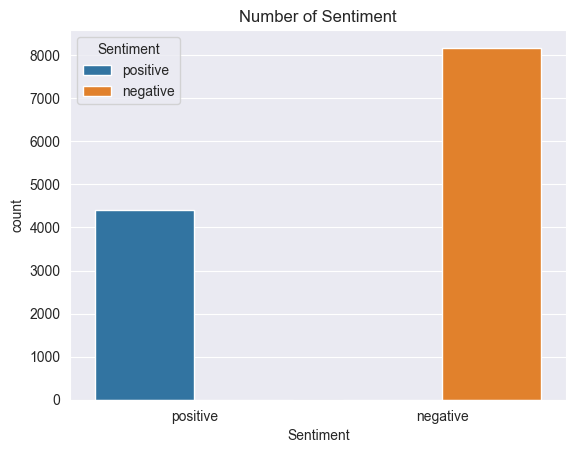

In [315]:
sns.set_style('darkgrid')

sns.countplot(data=df1, x="Sentiment", hue="Sentiment").set(title='Number of Sentiment')

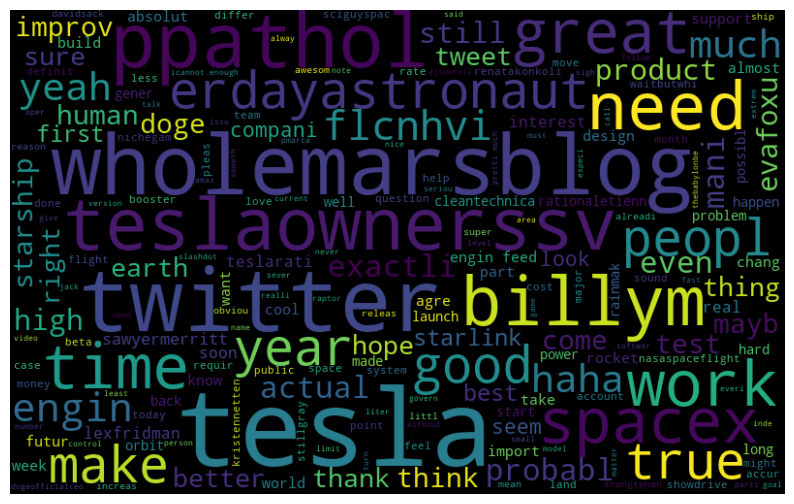

In [177]:
from wordcloud import WordCloud 

all_words = ' '.join([text for text in df1['clean_text']])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words) 

plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off') 
plt.show()

In [178]:
all_words_list = all_words.split()
all_words_count = collections.Counter(all_words_list)
all_words_count.most_common(15)

[('tesla', 1077),
 ('spacex', 608),
 ('twitter', 578),
 ('wholemarsblog', 520),
 ('ppathol', 461),
 ('teslaownerssv', 436),
 ('good', 405),
 ('billym', 401),
 ('time', 389),
 ('like', 388),
 ('erdayastronaut', 384),
 ('work', 376),
 ('engin', 375),
 ('make', 365),
 ('need', 360)]

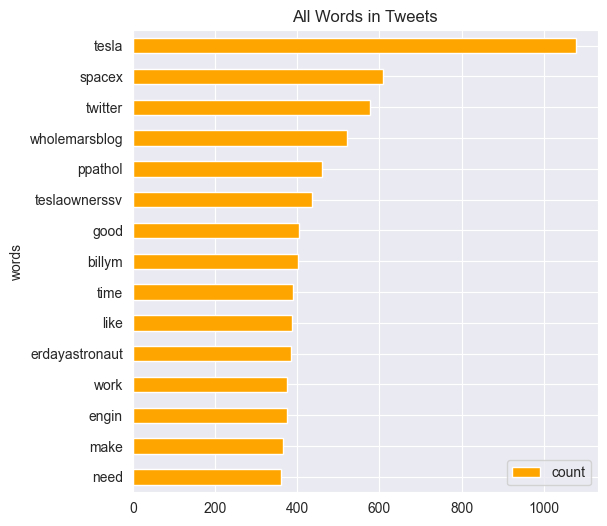

In [179]:
df_all_words_count = pd.DataFrame(all_words_count.most_common(15),
                             columns=['words', 'count'])

fig, ax = plt.subplots(figsize=(6, 6))

df_all_words_count.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="orange")

ax.set_title("All Words in Tweets")

plt.show()

In [ ]:
all_words_list = all_words.split()
pos_words_list = positive_words.split()
neg_words_list = negative_words.split()

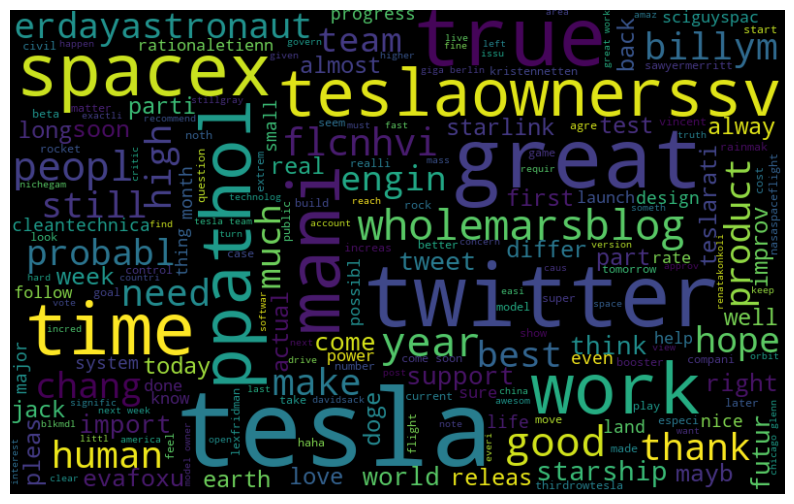

In [338]:
positive_words =' '.join([text for text in df1['clean_text'][df1['Sentiment'] == 'positive']]) 
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(positive_words)
pos_words_list = positive_words.split()

plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off') 
plt.show()

In [339]:
pos_words_count = collections.Counter(pos_words_list)
pos_words_count.most_common(15)

[('tesla', 496),
 ('great', 280),
 ('twitter', 241),
 ('spacex', 234),
 ('true', 206),
 ('work', 205),
 ('year', 178),
 ('mani', 175),
 ('time', 172),
 ('good', 170),
 ('teslaownerssv', 159),
 ('peopl', 158),
 ('wholemarsblog', 156),
 ('ppathol', 150),
 ('also', 126)]

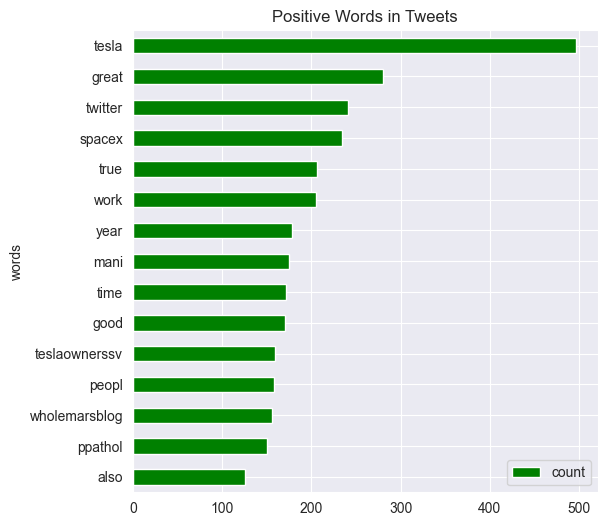

In [340]:
df_pos_words_count = pd.DataFrame(pos_words_count.most_common(15),
                             columns=['words', 'count'])

fig, ax = plt.subplots(figsize=(6, 6))

df_pos_words_count.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="green")

ax.set_title("Positive Words in Tweets")

plt.show()

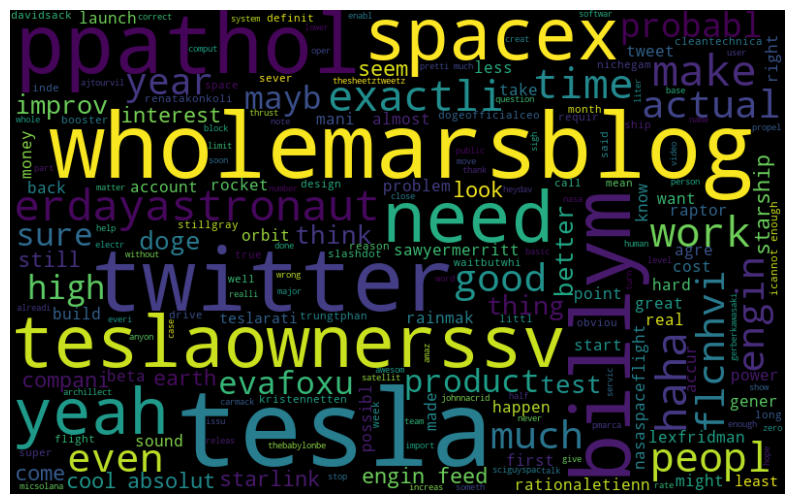

In [343]:
negative_words =' '.join([text for text in df1['clean_text'][df1['Sentiment'] == 'negative']]) 
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(negative_words)
neg_words_list = negative_words.split()

plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off') 
plt.show()

In [344]:
neg_words_count = collections.Counter(neg_words_list)
neg_words_count.most_common(15)

[('tesla', 581),
 ('spacex', 374),
 ('wholemarsblog', 364),
 ('twitter', 337),
 ('ppathol', 311),
 ('billym', 300),
 ('like', 279),
 ('teslaownerssv', 277),
 ('erdayastronaut', 273),
 ('engin', 269),
 ('need', 258),
 ('would', 245),
 ('make', 240),
 ('good', 235),
 ('much', 221)]

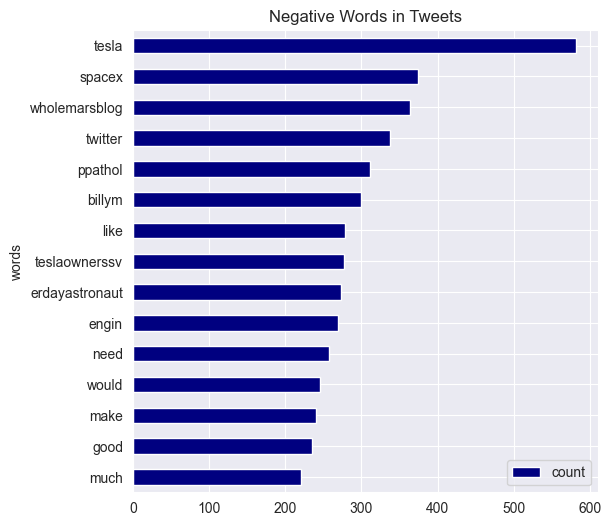

In [345]:
df_neg_words_count = pd.DataFrame(neg_words_count.most_common(15),
                             columns=['words', 'count'])

fig, ax = plt.subplots(figsize=(6, 6))

df_neg_words_count.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="navy")

ax.set_title("Negative Words in Tweets")

plt.show()

#### Timeline of each sentiment

In [316]:
df1['Date'] = pd.to_datetime(df1['Date']).dt.date
df1["Date_month"] = pd.to_datetime(df1['Date']).dt.month
df1['Date_month'] = df1['Date'].apply(lambda x: x.strftime('%Y %B'))\
df1['Date'] = pd.to_datetime(df1['Date'])
category_frequency = df1.groupby(['Date_month', 'Sentiment'])['Sentiment'].count()
category_frequency_pivot = category_frequency.unstack(level=1)

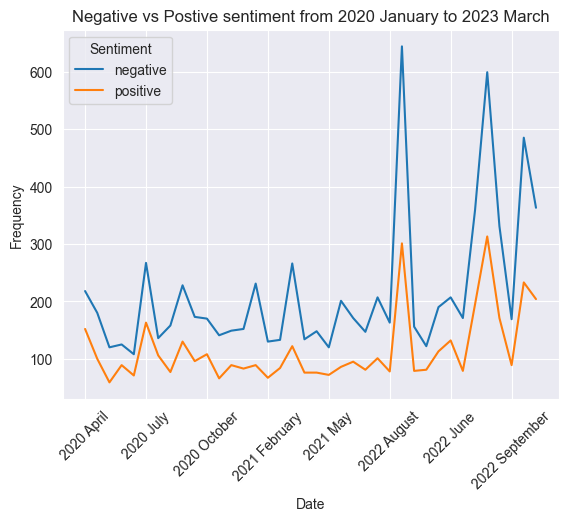

In [346]:
category_frequency_pivot.plot()
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.title('Negative vs Postive sentiment from 2020 January to 2023 March')
plt.xticks(rotation=45)
plt.show()